In [1]:
from skimage.transform import resize
from itertools import product
from collections import OrderedDict
from tqdm.notebook import tqdm
import datetime

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
#from thirdparty.Run import RunBuilder as RB
#from thirdparty.Run import RunManager as RM

from DataLoading import UdacityDataset as UD
from DataLoading import ConsecutiveBatchSampler as CB

%run Visualization.ipynb
#%run DataLoader.ipynb
device = torch.device("cuda")

# Model Definition

In [2]:
# Model definition and model loading

import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class TLearning(nn.Module):
    def __init__(self):
        super(TLearning,self).__init__()
        self.ResNet = models.resnet50(pretrained=True, progress=True)
        
        self.fc1 = nn.Linear(in_features =1000, out_features = 512, bias=True)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256, bias=True)
        self.fc3 = nn.Linear(in_features = 256, out_features = 64, bias=True)
        self.fc4 = nn.Linear(in_features = 64, out_features = 1, bias=True)
    def forward(self, Input):
        image = self.ResNet(Input)
        # input size = (1,3,224,224)-(Batches, Channels, Height, Width)
        # output size = (1, 1000)-(Batches, Feature)
        image = F.relu(self.fc1(image))
        # input size = (1,1000)-(batches, features)
        # output size = (1,512)-(batches, features)
        image = F.relu(self.fc2(image))
        # input size = (1,512)-(batches, features)
        # output size = (1,256)-(batches, features)
        image = F.relu(self.fc3(image))
        # input size = (1,256)-(batches, features)
        # output size = (1,64)-(batches, features)
        image = self.fc4(image)
        # input size = (1,64)-(batches, features
        # output size = (1,1)-(batches, features)
        return image

# Model Training / Loading [ don't Run this Part]

In [3]:
parameters = OrderedDict(
    learning_rate = [0.001],
    batch_size = [50],
    num_workers = [1],
    #shuffle = [True,False]
)
m = RM.RunManager()
writer = SummaryWriter('/export/jupyterlab/lintao/TransferLearning/runs/TLearning-No-Dropout-{}'.format(datetime.datetime.now()))
for run in RB.RunBuilder.get_runs(parameters):
    network = TLearning()
    network.cuda()
    network.to(device)
    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# modify the time to visible time format, also use it to check the sequency of pictures is from former to current
    
    transforming = [
                transforms.ToPILImage(),
                transforms.RandomAffine(0, translate=(0.2,0.2), scale=None, shear=None, resample=False, fillcolor=0),# shift
                transforms.RandomRotation(5, resample=False, expand=False, center=None, fill=0),# rotation
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0), # brightness
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False),# shadow
            ]
    
    udacity_dataset = UD.UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose(transforming),
                                     select_camera='center_camera')
    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UD.UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose(transforming),
                                     select_camera='center_camera',
                                     select_range=(0,split_point))

    validation_set = UD.UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose(transforming),
                                     select_camera='center_camera',
                                     select_range=(split_point,dataset_size))
    
    training_cbs = CB.ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1,use_all_frames=True)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    validation_cbs = CB.ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1,use_all_frames=True)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    m.begin_run( run,network,[run.batch_size,3,224,224] )
    for epoch in range(15):
        m.begin_epoch()
        for i, training_sample in enumerate(tqdm(training_loader,total=int(len(training_set)/50))):
            training_sample['image'] = training_sample['image'].squeeze()
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device)
            prediction = network(image)
            prediction = prediction.to(device)
            labels = angle.to(device)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0]:,:]
            training_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            writer.add_scalar('TLearning-train - No-Dropout - loss total epoch {}'.format(epoch), training_loss_angle,i)
            optimizer.step() # finishing calculation on gradient 
        print("Finished training epoch {}".format(epoch))
# Calculation on Validation Loss
        with torch.no_grad():  
            validation_loss = 0
            count = 0
            for i,Validation_sample in enumerate(tqdm(validation_loader, total=int(len(validation_set)/50))):
                Validation_sample['image'] = Validation_sample['image'].squeeze()
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                Validation_prediction = network(image)
                Validation_prediction = Validation_prediction.to(device)
                labels = angle.to(device)
                del param_values, image, angle
                if labels.shape[0]!=Validation_prediction.shape[0]:
                    Validation_prediction = Validation_prediction[-labels.shape[0]:,:]
                validation_loss_angle = F.mse_loss(Validation_prediction,labels,size_average=None, reduce=None, reduction='mean')
                validation_loss +=float(validation_loss_angle)
                writer.add_scalar('TLearning-Validation - No-Dropout - loss total epoch {}'.format(epoch), validation_loss_angle,i)
                count = i +1
                m.track_loss(validation_loss_angle)
                m.track_num_correct(Validation_prediction,labels) 
        m.end_epoch(validation_set)
        print("Finished validating epoch {}".format(epoch))
        Vloss = validation_loss / count
        writer.add_scalar('TLearning-Valid - No-Dropout - angle (RMSE) epoch {}'.format(epoch), Vloss)
        torch.save(network.state_dict(), "/export/jupyterlab/lintao/TransferLearning/Training_Model/TLearning_No_Dropout_epoch-{}".format(epoch))
    m.end_run()

,run,epoch,loss,accuracy,epoch duration/s,run duration/s,Input_size,learning_rate,batch_size,num_workers
0,1,1,0.000210,0.001134,3357.816981,3357.816985,"[50, 3, 224, 224]",0.001,50,1
1,1,2,0.000157,0.001430,3351.909662,6709.796542,"[50, 3, 224, 224]",0.001,50,1
2,1,3,0.000265,0.000937,3358.346314,10068.211974,"[50, 3, 224, 224]",0.001,50,1
3,1,4,0.000288,0.002071,3350.992712,13419.273046,"[50, 3, 224, 224]",0.001,50,1
4,1,5,0.000187,0.001381,3352.896388,16772.237674,"[50, 3, 224, 224]",0.001,50,1
5,1,6,0.000194,0.001183,3351.876642,20124.182547,"[50, 3, 224, 224]",0.001,50,1
6,1,7,0.000180,0.001726,3351.383524,23475.634808,"[50, 3, 224, 224]",0.001,50,1
7,1,8,0.000156,0.001726,3352.892265,26828.595343,"[50, 3, 224, 224]",0.001,50,1
8,1,9,0.000173,0.001627,3350.090995,30178.757004,"[50, 3, 224, 224]",0.001,50,1
9,1,10,0.000221,0.000888,3345.211557,33524.037453,"[50, 3, 224, 224]",0.001,50,1


Finished validating epoch 14


In [3]:
# Load Directly from disk

tl_model = TLearning().to(device)
tl_model.load_state_dict(torch.load("/export/jupyterlab/lintao/TransferLearning/Training_Model/TLearning_No_Dropout_epoch-7"))

<All keys matched successfully>

# Visualization

(64, 3, 7, 7)


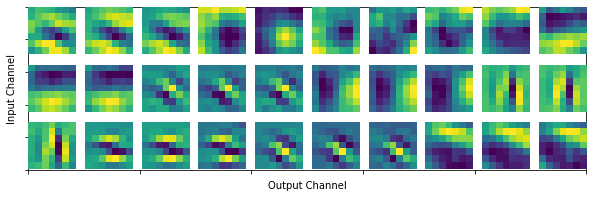

In [8]:
visualize_cnn(tl_model.ResNet.conv1)

### GradCAM

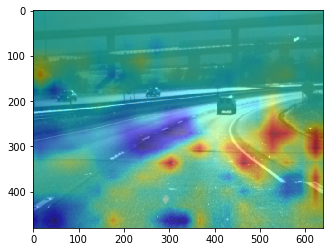

In [9]:
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')


# Load arbitrary data
sample = udacity_dataset[3693]
show_sample(sample)
input_image = sample['image'].reshape(-1, 3, 480, 640).cuda()

cam_extractor_tl = CamExtractorTLModel(tl_model)

# Forward pass
model_output = tl_model(input_image)

# Backward pass
tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].cuda().reshape(1,1))
loss.backward()

cam_image = cam_extractor_tl.to_image(height=480, width=640) # Use this line to extract CAM image from the model!
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5) # this shows CAM as overlay to the original input image


In [9]:
def Show_Sample(sample):
    r""" Helper function for (batch) sample visualization

    Args:
        sample: Dictionary
    """
    image_dims = len(sample['image'].shape)
    assert image_dims <= 5, "Unsupported image shape: {}".format(sample['image'].shape)
    if image_dims == 3:
        plt.imshow(sample['image'].permute(1,2,0))
    else:
        n0 = sample['image'].shape[0]
        n1 = sample['image'].shape[1] if image_dims == 5 else 1
        images_flattened = torch.flatten(sample['image'], end_dim=-4)
        fig, ax = plt.subplots(n0, n1, figsize=(25, 15))
        for i1 in range(n1):
            for i0 in range(n0):
                image = images_flattened[i0 * n1 + i1]
                axis = ax[i0, i1]
                axis.imshow(image.permute(1,2,0))
                axis.axis('off')
                axis.set_title("t={}".format(sample['timestamp'][i0][i1]))
                axis.text(10, 30, sample['frame_id'][i0][i1], color='red')

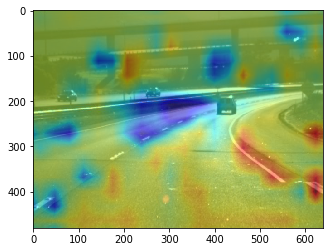

In [12]:
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')


# Load arbitrary data
sample = udacity_dataset[3693]
Show_Sample(sample)
input_image = sample['image'].reshape(-1, 3, 480, 640).cuda()

cam_extractor_tl = CamExtractorTLModel(tl_model)

# Forward pass
model_output = tl_model(input_image)

# Backward pass
tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].cuda().reshape(1,1))
loss.backward()

cam_image = cam_extractor_tl.to_image(height=480, width=640) # Use this line to extract CAM image from the model!
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5) # this shows CAM as overlay to the original input image


## Testing Stage

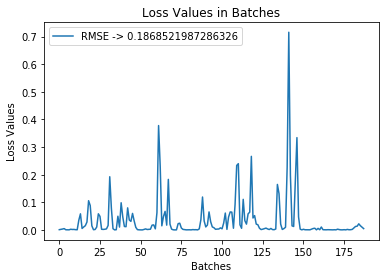

In [5]:
import matplotlib.pyplot as plt
import numpy as np
Batch_size = 30
testing_set = UD.UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_001_export_png/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_001_export_png/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera'
                                 )

length = len(testing_set)
testing_cbs = CB.ConsecutiveBatchSampler(data_source=testing_set, batch_size=Batch_size, shuffle=False, drop_last=False, seq_len=1,use_all_frames=True)
testing_loader = DataLoader(testing_set, sampler=testing_cbs, num_workers=1, collate_fn=(lambda x: x[0]))
del testing_cbs, testing_set

Loss = []
testing_loss = 0
count = 0
for i,testing_sample in enumerate(tqdm(testing_loader, total = int(length/Batch_size))):
    testing_sample['image'] = testing_sample['image'].squeeze()
    testing_sample['image'] = torch.Tensor(resize(testing_sample['image'], (Batch_size,3,224,224),anti_aliasing=True))

    param_values = [v for v in testing_sample.values()]
    image,angle = param_values[0],param_values[3]
    image = image.to(device)
    testing_prediction = tl_model(image)
    labels = angle.to(device)
    del param_values, image, angle
    if labels.shape[0]!=testing_prediction.shape[0]:
        testing_prediction = testing_prediction[-labels.shape[0]:,:]
    testing_loss_angle = F.mse_loss(testing_prediction,labels,size_average=None, reduce=None, reduction='mean')
    testing_loss +=float(testing_loss_angle)
    count += 1
    del testing_prediction
    #prediction = testing_prediction.squeeze()
    #Pred.append(prediction)
    Loss.append(float(testing_loss_angle))

Loss = np.array(Loss)
x = np.arange(len(Loss))
plt.plot(x,Loss,label = 'RMSE -> {}'.format(np.sqrt(np.mean(Loss))))
plt.xlabel('Batches')
plt.ylabel('Loss Values')
plt.title("Loss Values in Batches")
plt.legend()
plt.show()